#TASK 1.1
Write a function that computes the total buy volume for flex power, another that computes the total sell volume.

In [73]:
def compute_total_buy_volume(sql_database):
    import sqlite3
    import pandas as pd
    with sqlite3.connect(sql_database) as conn:
        df = pd.read_sql_query("SELECT * FROM epex_12_20_12_13", conn)
    total_buy_volume = df[df['side'] == 'buy']['quantity'].sum()
    print("Total Buy Volume:", total_buy_volume)

def compute_total_sell_volume(sql_database):
    import sqlite3
    import pandas as pd
    with sqlite3.connect(sql_database) as conn:
        df = pd.read_sql_query("SELECT * FROM epex_12_20_12_13", conn)
    total_sell_volume = df[df['side'] == 'sell']['quantity'].sum()
    print("Total Sell Volume:", total_sell_volume)


In [74]:
compute_total_buy_volume("trades.sqlite")
compute_total_sell_volume("trades.sqlite")

Total Buy Volume: 28
Total Sell Volume: 53


#Task 1.2:
Write a function that computes the PnL (profit and loss) of each strategy in euros. It's defined as the sum of the incomes realized with each trade.

If we sell energy, our income is quantity * price since we got money for our electricity. If we buy energy, our income is -quantity * price.

In [75]:
def compute_pnl(strategy, sql_database):
    from datetime import datetime, timezone
    import sqlite3
    import pandas as pd

    with sqlite3.connect(sql_database) as conn:
        df = pd.read_sql_query("SELECT * FROM epex_12_20_12_13", conn)


    # Filter trades by strategy
    df = df[df['strategy'] == strategy]

    if df.empty:
        print(f"No trades found for {strategy}")
        return 0.0
    
    df['income'] = df.apply(
        lambda row: row['quantity'] * row['price'] if row['side'] == 'sell'
        else -row['quantity'] * row['price'], axis=1
    )

    # Compute total PnL
    total_pnl = float(df['income'].sum())

    return {
        "strategy":     strategy,
        "value":        total_pnl,
        "unit":         "euro",
        "capture_time": datetime.now(timezone.utc).isoformat() + "Z"
    }



In [76]:
compute_pnl("strategy_1", "trades.sqlite")

{'strategy': 'strategy_1',
 'value': -50.0,
 'unit': 'euro',
 'capture_time': '2025-04-24T15:08:00.154873+00:00Z'}

#TASK 1.3:
Expose the function defined in the second task as an entrypoint of a web application.

https://sauradeep2013.pythonanywhere.com/

#TASK 2.6:
How much revenue would you generate with a battery with a capacity of 1 MWh which you can fully charge and fully discharge (1 Cycle) every day in 2021? Think about when you would charge and when you would discharge and apply this rule for each day of the year.

My answer: Total achievable extra revenue with a 1 MWh batter is 50512.18 EUR...Please see workings below.


In [6]:
import pandas as pd
df= pd.read_excel(
    "/Users/apple/Desktop/QuantChallenge_Deep/analysis_task_data_for_python.xlsx",
    sheet_name="DE_Wind_PV_Prices",
    header=0
    )
df.head()




,hour,time,Wind Day Ahead Forecast [in MW],Wind Intraday Forecast [in MW],PV Day Ahead Forecast [in MW],PV Intraday Forecast [in MW],Day Ahead Price hourly [in EUR/MWh],Intraday Price Price Quarter Hourly [in EUR/MWh],Intraday Price Hourly [in EUR/MWh],Imbalance Price Quarter Hourly [in EUR/MWh],...,Day of the week,Time slot (15 mins),Hour_adj,Wind Day Ahead Forecast [MWh],Wind Intraday Forecast [MWh],PV Day Ahead Forecast [MWh],PV Intraday Forecast [MWh],Hourly value in Day Ahead Markets Wind,Hourly value in Day Ahead Markets PV,Renewable energy production_Intraday (MWh)
0,0,2021-01-01 00:00:00,4433,4709,0,0,50.87,44.409894,48.682294,13.33,...,Friday,00:00,1,1108.25,1177.25,0.0,0.0,56376.6775,0.0,1177.25
1,0,2021-01-01 00:15:00,4286,4507,0,0,50.87,52.139142,48.682294,-0.92,...,Friday,00:15,1,1071.50,1126.75,0.0,0.0,54507.2050,0.0,1126.75
2,0,2021-01-01 00:30:00,4142,4307,0,0,50.87,50.160255,48.682294,60.26,...,Friday,00:30,1,1035.50,1076.75,0.0,0.0,52675.8850,0.0,1076.75
3,0,2021-01-01 00:45:00,3991,4181,0,0,50.87,41.342082,48.682294,-12.05,...,Friday,00:45,1,997.75,1045.25,0.0,0.0,50755.5425,0.0,1045.25
4,1,2021-01-01 01:00:00,3847,4094,0,0,48.19,64.424013,46.165819,96.09,...,Friday,01:00,2,961.75,1023.50,0.0,0.0,46346.7325,0.0,1023.50


To answer this question, the idea is to find the maximum spread between 2 prices daily from either the quarterly intraday market or the hourly day ahead market, such that the time for the lower price is before that of the higher price. 

In [161]:
import numpy as np


class QuoteFlattener:
    """
    Flatten two price columns into a quote list and
    find the max-spread (buy, sell) pair for every calendar day.

    Parameters
    ----------
    df : pandas.DataFrame
    date_col : str      column holding the date (one per row)
    slot_col : str      15-minute time-slot label
    price_cols : tuple(str, str)
        exactly two columns that contain prices
    """
    # ----------  constructor  -----------------------------------------
    def __init__(self, df, date_col, slot_col, price_cols):
        self.df         = df
        self.date_col   = date_col
        self.slot_col   = slot_col
        self.price_cols = price_cols     # tuple of two column names

    # ----------  step 1: build tidy quote table  ----------------------
    def build_quotes(self):
        """Return DataFrame with Date | Slot | Market | Price."""
        rows = []
        for _, row in self.df.iterrows():
            date_val = row[self.date_col]
            slot_val = row[self.slot_col]
            for market in self.price_cols:
                rows.append({
                    "Date"  : date_val,
                    "Slot"  : slot_val,
                    "Market": market,
                    "Price" : row[market]
                })
        return pd.DataFrame(rows)

    # ----------  step 2: find best daily spread  ----------------------
    def best_pairs(self):
        """
        For each day, pick the (buy, sell) quotes that maximise
        (sell_price – buy_price) with the constraint Slot_buy < Slot_sell.

        Returns
        -------
        DataFrame with columns
            Date  | buy_slot  | buy_market  | buy_price
                  | sell_slot | sell_market | sell_price | spread
        """
        quotes = (
            self.build_quotes()
              .sort_values(["Date", "Slot"])        # chronological order
              .reset_index(drop=True)
        )

        results = []

        # --- process one calendar day at a time ----------------------
        for d, grp in quotes.groupby("Date", sort=True):
            prices = grp["Price"].to_numpy()

            min_pos = 0            # index of cheapest price seen so far
            best_buy = best_sell = 0
            best_spread = -np.inf

            # single pass through that day's quotes
            for i in range(1, len(prices)):
                spread = prices[i] - prices[min_pos]
                if spread > best_spread:
                    best_spread = spread
                    best_buy, best_sell = min_pos, i
                if prices[i] < prices[min_pos]:
                    min_pos = i

            buy_quote  = grp.iloc[best_buy]
            sell_quote = grp.iloc[best_sell]

            results.append({
                "Date"        : d,
                "buy_slot"    : buy_quote["Slot"],
                "buy_market"  : buy_quote["Market"],
                "buy_price"   : buy_quote["Price"],
                "sell_slot"   : sell_quote["Slot"],
                "sell_market" : sell_quote["Market"],
                "sell_price"  : sell_quote["Price"],
                "spread"      : best_spread
            })

        return pd.DataFrame(results)


In [162]:
flattener = QuoteFlattener(
    df,
    date_col  ="Date",
    slot_col  ="Time slot (15 mins)",
    price_cols=("Intraday Price Price Quarter Hourly  [in EUR/MWh]",
                "Day Ahead Price hourly [in EUR/MWh]")
)

daily_pairs = flattener.best_pairs()
print(daily_pairs.head())

        Date buy_slot                                         buy_market  \
0 2021-01-01    07:00  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
1 2021-01-02    02:45  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
2 2021-01-03    05:45  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
3 2021-01-04    02:00                Day Ahead Price hourly [in EUR/MWh]   
4 2021-01-05    00:00                Day Ahead Price hourly [in EUR/MWh]   

   buy_price sell_slot                                        sell_market  \
0  30.332050     22:00  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
1  20.033819     18:00  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
2 -26.391794     19:00  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
3  24.650000     12:00  Intraday Price Price Quarter Hourly  [in EUR/MWh]   
4  37.540000     12:15  Intraday Price Price Quarter Hourly  [in EUR/MWh]   

   sell_price      spread  
0   85.542894   55.210844  
1   68.513021   48.47920

To find the revenue one could generate with a battery with a capacity of 1 MWh which one can fully charge and fully discharge (1 Cycle) every day in 2021, I would just sum spread of the daily pairs as the price is already for 1 MWh.

In [ ]:

total_spread = daily_pairs["spread"].sum()
print(f"Total achievable extra revenue with a 1 MWh batter is {total_spread:.2f} EUR")

Total achievable extra revenue with a 1 MWh batter is 50512.18 EUR


#TASK 2.7  Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable produciton etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

In [7]:
df['DA-ID']= df['Day Ahead Price hourly [in EUR/MWh]'] - df['Intraday Price Price Quarter Hourly  [in EUR/MWh]']

In [8]:
df['Renewable production_DayAhead [MWh]']= df['PV Day Ahead Forecast [MWh]'] + df['Wind Day Ahead Forecast [MWh]']

In [9]:
import pandas as pd
import numpy as np

For every 15-minute slot we build three “typical price” features— one for the Day-Ahead hourly market, one for the Intraday quarter-hour market, and one for the Imbalance quarter-hour market—using a slot-specific rolling average of recent history:

* **Slot window:** the current quarter-hour plus the two slots before and after (5 slots total).  
* **Look-back horizon:**  
  * **Weekday row →** scan the previous **7 calendar days** but keep **only weekday observations**.  
  * **Weekend row →** scan the previous **14 calendar days** but keep **only weekend observations** (typically four weekend days).  
* **Computation:** average the price values found for those 5 slots on the selected past days, giving a robust reference that blends both the usual level and intra-hour pattern for that slot type (weekday vs weekend).

The result is three rolling-average columns that provide a context-aware “expected” DA, ID, and Imbalance price for each quarter-hour timestamp.

In [10]:
 
df = df.drop_duplicates(
    subset=["Date", "Time slot (15 mins)"],
    keep="first"
).reset_index(drop=True)

# ------------------------ 1. Settings ------------------------
WINDOW_SLOTS     = 2
LOOKBACK_WEEKDAY = 7
LOOKBACK_WEEKEND = 14
WEEKEND_NAMES    = {"Saturday", "Sunday"}

# ---------------- 2. Build composite ID & weekend flag ----------------
# Normalize Date to string YYYY-MM-DD and build ID = "YYYY-MM-DD_HH:MM"
df["Date_str"]  = pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d")
df["ID"]        = df["Date_str"] + "_" + df["Time slot (15 mins)"]
df["is_weekend"]= df["Day of the week"].isin(WEEKEND_NAMES)

# ----------- 3. Detect the exact source column names -------------
col_da  = next(c for c in df.columns if "Day Ahead Price hourly" in c)
col_id  = next(c for c in df.columns if "Intraday Price Price Quarter Hourly" in c)
col_imb = next(c for c in df.columns if "Imbalance Price Quarter Hourly" in c)

# ------------- 4. Precompute slot neighbours -------------
slot_order   = sorted(
    df["Time slot (15 mins)"].unique(),
    key=lambda s: pd.to_datetime(s, format="%H:%M").time()
)
slot_to_idx  = {s:i for i,s in enumerate(slot_order)}
slot_neighbours = {
    s: slot_order[max(0, slot_to_idx[s]-WINDOW_SLOTS) : 
                  slot_to_idx[s]+WINDOW_SLOTS+1]
    for s in slot_order
}

# ---------- 5. Build past‐IDs map, filtering by same day‐type ----------
past_ids_map = {}
for _, row in df.iterrows():
    cur_id   = row["ID"]
    date_str = row["Date_str"]
    slot     = row["Time slot (15 mins)"]
    is_wend  = row["is_weekend"]
    days     = LOOKBACK_WEEKEND if is_wend else LOOKBACK_WEEKDAY

    lst = []
    for d in range(1, days + 1):
        prev = pd.to_datetime(date_str) - pd.Timedelta(days=d)
        prev_str = prev.strftime("%Y-%m-%d")

        # **only include if prev is same weekend/weekday type**
        prev_dayname = prev.day_name()
        if (prev_dayname in WEEKEND_NAMES) != is_wend:
            continue

        # add that day's neighbour slots
        for nbr in slot_neighbours[slot]:
            lst.append(f"{prev_str}_{nbr}")

    past_ids_map[cur_id] = lst


# ----------- 6. Create price lookup dicts ----------------
da_price_dict  = df.set_index("ID")[col_da].to_dict()
id_price_dict  = df.set_index("ID")[col_id].to_dict()
imb_price_dict = df.set_index("ID")[col_imb].to_dict()

# ------------ 7. Helper to compute mean fast -------------
def mean_from_dict(id_list, price_dict):
    vals = [price_dict[i] for i in id_list if i in price_dict]
    return np.mean(vals) if vals else np.nan

# ------------ 8. Compute the three feature columns -----------
df["DA_price_avg_prev"]    = [mean_from_dict(past_ids_map[i], da_price_dict)
                              for i in df["ID"]]
df["ID_QH_price_avg_prev"] = [mean_from_dict(past_ids_map[i], id_price_dict)
                              for i in df["ID"]]
df["Imb_QH_price_avg_prev"]= [mean_from_dict(past_ids_map[i], imb_price_dict)
                              for i in df["ID"]]

# ------------- 9. Clean up helper column ----------------
df.drop(columns=["Date_str"], inplace=True)





For each quarter-hour slot we look back seven days and examine that slot plus the two slots before and after (five slots total).  
* **Renewable-forecast error trend:** we collect the Day-Ahead minus Intraday renewable-forecast errors for those five slots over the seven-day window.  
* **DA–ID spread trend:** we do the same for the Day-Ahead hourly price minus the Intraday quarter-hourly price.

For each set we take all positive differences, average them, and then multiply by the fraction of times the difference was actually positive. The same is done for negatives.  
Because big deviations that occur rarely are down-weighted, the resulting number captures not just the size of the bias but also how consistently it points in one direction.

In [11]:
df["Renewable Forecast Error"] = (
    df["Renewable production_DayAhead [MWh]"]
  - df["Renewable energy production_Intraday (MWh)"]
)


In [12]:

# 0. Drop any exact duplicate slots
df = df.drop_duplicates(
    subset=["Date", "Time slot (15 mins)"],
    keep="first"
).reset_index(drop=True)

# 1. Settings
WINDOW_SLOTS  = 2    # ±2 slots → 5-slot band
LOOKBACK_DAYS = 7    # always look back exactly 7 days
# (weekend vs weekday distinction removed)

# 2. Composite ID
df["Date_str"] = pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d")
df["ID"]       = df["Date_str"] + "_" + df["Time slot (15 mins)"]

# 3. Precompute slot neighbours
slot_order  = sorted(
    df["Time slot (15 mins)"].unique(),
    key=lambda s: pd.to_datetime(s, format="%H:%M").time()
)
slot_to_idx = {s: i for i, s in enumerate(slot_order)}
slot_neighbours = {
    s: slot_order[max(0, slot_to_idx[s] - WINDOW_SLOTS)
                  : slot_to_idx[s] + WINDOW_SLOTS + 1]
    for s in slot_order
}

# 4. Build past-IDs map (no weekend filter)
past_ids_map = {}
for _, row in df.iterrows():
    cur_id   = row["ID"]
    date_str = row["Date_str"]
    slot     = row["Time slot (15 mins)"]
    lst      = []
    for d in range(1, LOOKBACK_DAYS + 1):
        prev_dt  = (pd.to_datetime(date_str) - pd.Timedelta(days=d))
        prev_str = prev_dt.strftime("%Y-%m-%d")
        for nbr in slot_neighbours[slot]:
            lst.append(f"{prev_str}_{nbr}")
    past_ids_map[cur_id] = lst

# 5. Ensure we have the two source columns
df["Renewable Forecast Error"] = (
    df["Renewable production_DayAhead [MWh]"]
  - df["Renewable energy production_Intraday (MWh)"]
)
# “DA-ID” is already in your DF as the spread column

# 6. Build lookup dicts for O(1) access
err_dict    = df.set_index("ID")["Renewable Forecast Error"].to_dict()
spread_dict = df.set_index("ID")["DA-ID"].to_dict()

# 7. Weighted‐average helper
def weighted_mean_from_dict(id_list, price_dict):
    vals = [price_dict[i] for i in id_list if i in price_dict]
    if not vals:
        return np.nan
    pos = [v for v in vals if v > 0]
    neg = [v for v in vals if v < 0]
    N   = len(vals)
    return sum(pos) * (len(pos)/N) + sum(neg) * (len(neg)/N)

# 8. Compute the two trend features
df["Renewable_forecast_error_trend"] = [
    weighted_mean_from_dict(past_ids_map[i], err_dict)
    for i in df["ID"]
]
df["DA-ID_Spread_trend"]  = [
    weighted_mean_from_dict(past_ids_map[i], spread_dict)
    for i in df["ID"]
]

# 9. Cleanup
df.drop(columns=["Date_str"], inplace=True)



Now we have our X feature space to train our decision tree. Below, I have used the data we have to get Y i.e. Long or Short for every time we have data on for 2021. 

For each time stamp (15 min), if (ID) Intraday Price Price Quarter Hourly  [in EUR/MWh] > (DA) Day Ahead Price hourly [in EUR/MWh] then we go Long, and if Intraday Price Price Quarter Hourly  [in EUR/MWh] < Day Ahead Price hourly [in EUR/MWh], we go short. However we will need to check with the Imbalance Price Quarter Hourly  [in EUR/MWh]. The sign of the Imbalance Price, gives us an indication of whether there is a system shortage or overload. If it is positive, then there is a shortage, i.e. there is need for energy to the grid, and contribution to the grid is rewarded by the price mentioned. Such a position is ideal to go long, as there will be demand for energy in the intraday markets, and one can sell for higher prices. However if the sign of the Imbalance Price is negative there is over supply, thus additional energy is penalised, and the ideal strategy in such a market is to go short i.e. buy back energy at reduced prices that what one sold at on day ahead markets, and make a profit. 


 SO we will augment our prior strategy based on ID and DA to include the below:
 If  Imbalance price > 0  and we are currently following long based on just DA and ID, then keep long, but if just based on ID and DA we predict short, then we calculate the return for 1 Mwh that is DA-ID, if this is this is less than the imbalance predicted then, we change to long instead.  Now if Imbalance price < 0, and we are following short then we keep short, but if we are going long, then is profit from long, ID- DA is less than the absolute value of the imbalance price, then we change strategy to short.

In [13]:
def decide_strategy(row):
    da   = row["Day Ahead Price hourly [in EUR/MWh]"]
    id_qh = row["Intraday Price Price Quarter Hourly  [in EUR/MWh]"]
    imb  = row["Imbalance Price Quarter Hourly  [in EUR/MWh]"]

    # 1) Baseline: Long if ID > DA, else Short
    strat = "Long" if id_qh > da else "Short"

    # 2) Imbalance adjustment
    if imb > 0:
        # system shortage → bias Long
        if strat == "Short" and (da - id_qh) < imb:
            strat = "Long"
    else:
        # system oversupply → bias Short
        if strat == "Long" and (id_qh - da) < abs(imb):
            strat = "Short"

    return strat

df["Strategy"] = df.apply(decide_strategy, axis=1)


Below we are fitting the model that will provide us our trading strategy. Our feature space includes all the parameters that our strategy takes to predict its position i.e. long or short. These are all based on information that would be available before the Day Ahead Auction at 12:00.


Renewable production_DayAhead [MWh]- Day-ahead forecast of total renewable generation (wind + solar) for the 15-min interval, expressed in megawatt-hours.  Higher values signal larger expected green supply entering the market. 

Time slot (15 mins)- Categorical label of the intraday quarter-hour (e.g., “17:30”).  Captures systematic price patterns tied to demand peaks and ramp periods. 

Day of the week - Categorical indicator (“Monday”…“Sunday”) reflecting working-day vs. weekend behaviour.  Prices and imbalance risks differ by weekday due to load profiles and plant scheduling. 

DA_price_avg_prev-  Rolling average of historical Day-Ahead hourly prices for the same slot (±2 neighbours) over the last 5 weekdays for weekday prices and last 2 weekends for weekend prices.  Encodes the typical DA level the market expects at this time.

ID_QH_price_avg_prev- Rolling average of Intraday quarter-hour prices for the same slot (±2) over the last 5 weekdays for weekday prices and last 2 weekends for weekend prices.  Provides a local reference for how ID prices normally trade. 

Imb_QH_price_avg_prev- Rolling average of quarter-hour Imbalance prices for the slot (±2) over the last 5 weekdays for weekday prices and last 2 weekends for weekend prices.  Summarises recent system-balancing cost or reward at this time.

Renewable_forecast_error_trend- Weighted 7-day trend of (Day-Ahead – Intraday) renewable-forecast errors for the slot window (±2). Big errors count most and are down-weighted if they occur rarely, so the score signals a persistent over- or under-forecast bias, not one-off spikes.

DA-ID_Spread_trend- Weighted 7-day trend of (Day-Ahead hourly – Intraday quarter-hourly) price spreads for the same slot window. Combines spread size with how frequently that sign repeats, highlighting a stable Long-leaning (ID > DA) or Short-leaning (DA > ID) price edge.

[LightGBM] [Info] Number of positive: 5253, number of negative: 29432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34685, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
🔍 Best threshold by F1-score: 0.667
Precision: 0.54, Recall: 0.42, F1: 0.47

Test-set accuracy:   0.855
Test-set error rate: 0.145

Classification Report (test set):
              precision    recall  f1-score   support

        Long       0.90      0.94      0.92       298
       Short       0.53      0.40      0.45        53

    accuracy                           0.85       351
   macro avg       0.71      0.67      0.68       351
weig

/Applications/anaconda3/envs/FLX_PWR_Challenge/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


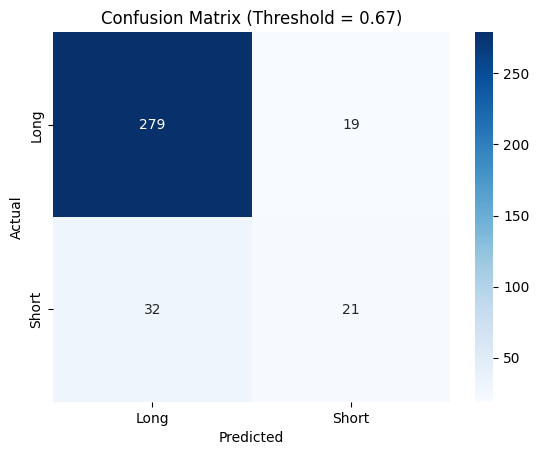

In [49]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Clean and prep DataFrame
df_model = df.copy()
df_model["Time slot (15 mins)"] = df_model["Time slot (15 mins)"].astype(str)
df_model["Day of the week"] = df_model["Day of the week"].astype(str)

# 1. Define features and target
feature_cols = [
    "Renewable production_DayAhead [MWh]",
    "Time slot (15 mins)",
    "Day of the week",
    "DA_price_avg_prev",
    "ID_QH_price_avg_prev",
    "Imb_QH_price_avg_prev",
    "Renewable_forecast_error_trend",
    "DA-ID_Spread_trend"
]
X = df_model[feature_cols]
y = df_model["Strategy"]  # "Long" or "Short"

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.01,
    stratify=y,
    random_state=42
)

# 3. Preprocessing
numeric_features = [
    "Renewable production_DayAhead [MWh]",
    "DA_price_avg_prev",
    "ID_QH_price_avg_prev",
    "Imb_QH_price_avg_prev",
    "Renewable_forecast_error_trend",
    "DA-ID_Spread_trend"
]
categorical_features = ["Time slot (15 mins)", "Day of the week"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

# 4. LightGBM pipeline with class balancing
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LGBMClassifier(
        objective="binary",
        class_weight="balanced",  # Handles imbalance
        random_state=42,
        n_jobs=1
    ))
])

# 5. Fit model
pipe.fit(X_train, y_train)

# 6. Predict probabilities for "Short"
short_class_idx = list(pipe.classes_).index("Short")
y_proba = pipe.predict_proba(X_test)[:, short_class_idx]

# 7. Get optimal threshold via F1
y_test_binary = (y_test == "Short").astype(int)
prec, rec, thresh = precision_recall_curve(y_test_binary, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1)
best_thresh = thresh[best_idx]

print(f"🔍 Best threshold by F1-score: {best_thresh:.3f}")
print(f"Precision: {prec[best_idx]:.2f}, Recall: {rec[best_idx]:.2f}, F1: {f1[best_idx]:.2f}")

# 8. Apply threshold
y_pred_bin = (y_proba > best_thresh).astype(int)
label_map = {"Long": 0, "Short": 1}
inv_map = {v: k for k, v in label_map.items()}
y_pred_label = [inv_map[val] for val in y_pred_bin]

# 9. Evaluate
test_acc = accuracy_score(y_test, y_pred_label)
test_err = 1 - test_acc

print(f"\nTest-set accuracy:   {test_acc:.3f}")
print(f"Test-set error rate: {test_err:.3f}")
print("\nClassification Report (test set):")
print(classification_report(y_test, y_pred_label, target_names=["Long", "Short"]))

# 10. Confusion matrix
cm = confusion_matrix(y_test, y_pred_label, labels=["Long", "Short"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Long", "Short"], yticklabels=["Long", "Short"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()


The above model is very good at spotting moments when we should stay long (hold or sell power later at a higher price) but only fair at warning us to go short (sell first, buy back cheaper).

Overall hit-rate: 85 % of 15-minute slots were classified correctly.

Long calls: 90 % precision and 94 % recall—so almost every “long” alert is right, and we rarely miss a genuine long opportunity.

Short calls: 45 % F1-score— so about half of the real short situations are missed or mis-flagged.

Why the bias?
Most historical data points are “long” cases, and because the model learns from what it sees most, it becomes less efficient about predicting shorts. To balance performance we’d need to give more short examples or explore other features that could perhaps better capture "short" cases.

Now for the test set, we apply our strategy, and calculate the income that we made for a 100MW position. We will show the cumulative performance of our position for the year 2021.

A 100 MW, position means for every quarter hour, we are able to trade 25 MWh of power. We keep this is mind for our calculations below.

/Applications/anaconda3/envs/FLX_PWR_Challenge/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


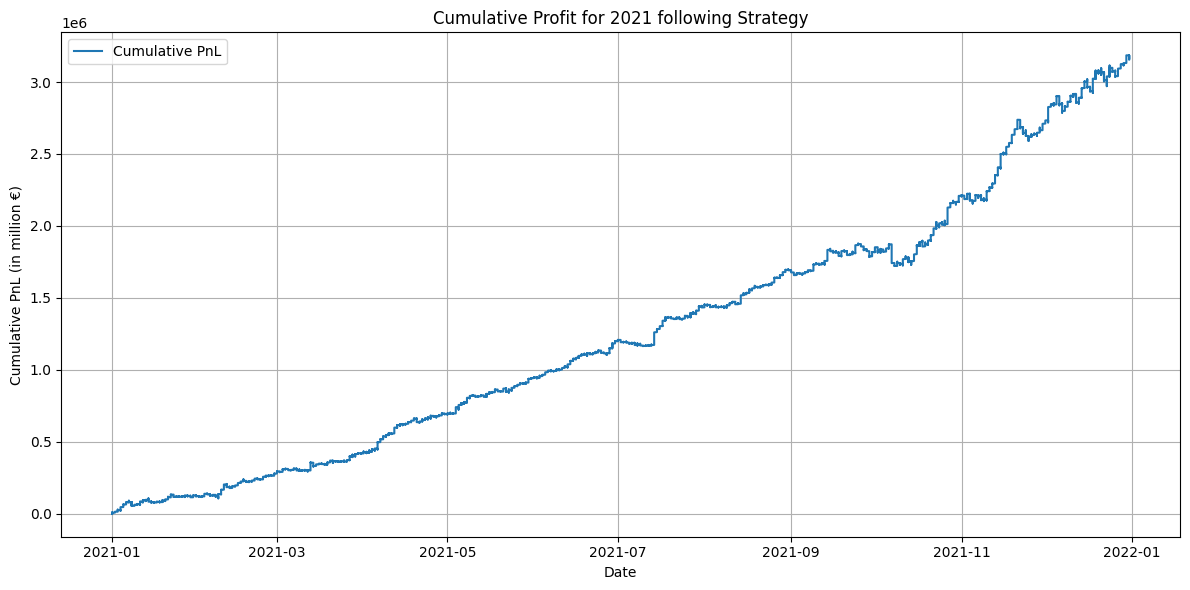

In [56]:
# -----------------------------
# Predict probabilities + threshold tuning
# -----------------------------
short_class_idx = list(pipe.named_steps["clf"].classes_).index("Short")
y_proba = pipe.predict_proba(X)[:, short_class_idx]
y_binary = (y == "Short").astype(int)

prec, rec, thresh = precision_recall_curve(y_binary, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1)
best_thresh = thresh[best_idx]

# -----------------------------
# Final predictions
# -----------------------------
label_map = {"Long": 0, "Short": 1}
inv_map = {v: k for k, v in label_map.items()}
y_pred_bin = (y_proba > best_thresh).astype(int)
y_pred_label = [inv_map[val] for val in y_pred_bin]
df_model["Predicted_Strategy"] = y_pred_label

# -----------------------------
# PnL logic
# -----------------------------
df_model["PnL"] = df_model.apply(
    lambda row: 25 * (row["Intraday Price Price Quarter Hourly  [in EUR/MWh]"] - row["Day Ahead Price hourly [in EUR/MWh]"])
    if row["Predicted_Strategy"] == "Long"
    else 25 * (row["Day Ahead Price hourly [in EUR/MWh]"] - row["Intraday Price Price Quarter Hourly  [in EUR/MWh]"]),
    axis=1
)

# -----------------------------
# Cumulative plot for 2021
# -----------------------------

df_model["Cumulative_PnL"] = df_model["PnL"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_model["Date"], df_model["Cumulative_PnL"], label="Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (in million €)")
plt.title("Cumulative Profit for 2021 following Strategy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()